In [99]:
import pandas as pd
import numpy as np

import datetime 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
# Import dataset
print("Loading dataset...")
walmart_sales = pd.read_csv("Walmart_Store_sales.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [101]:
# Basic stats
print("Number of rows : {}".format(walmart_sales.shape[0]))
print()

print("Number of columns : {}".format(walmart_sales.shape[1]))
print()

print("Display of dataset: ")
display(walmart_sales.head())
print()

print("Basics statistics: ")
data_desc = walmart_sales.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*walmart_sales.isnull().sum()/walmart_sales.shape[0])

Number of rows : 150

Number of columns : 8

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

- The target is the column "Weekly_Sales" (there are missing values)
- There are mising values in all columns except in the column Stores 
- CPI means consumer price index.

EDA

In [102]:
# Univariate analysis
# Distribution of each numeric variable
num_features = ["Temperature", "Fuel_Price", "Unemployment", "CPI", "Weekly_Sales"]
for i in range(len(num_features)):
    fig = px.histogram(walmart_sales[num_features[i]])
    fig.show()

There are outliers for Unemployment and CPI. 

In [103]:
# Univariate analysis
# Barplot of each qualitative variable
cat_features = ['Date']
for i in range(len(cat_features)):
    fig = px.bar(walmart_sales[cat_features[i]])
    fig.show()

In [104]:
# Univariate analysis
# Distribution of some categorical variables 
catbis_features = ["Store", "Holiday_Flag"]
for i in range(len(catbis_features)):
    fig = px.histogram(walmart_sales[catbis_features[i]])
    fig.show()

In [105]:
# Correlation matrix
corr_matrix = walmart_sales.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

- Strong correlation for features Store and CPI. We keep it because they give additional information.
- Strong Correlation with the target Weekly Sales : in order features CPI (-0.29), temperature (-0.17) and Store (0.12) 

In [106]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(walmart_sales)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

CPI and Unemployment have the strongest correlations with the target Weekly sales.

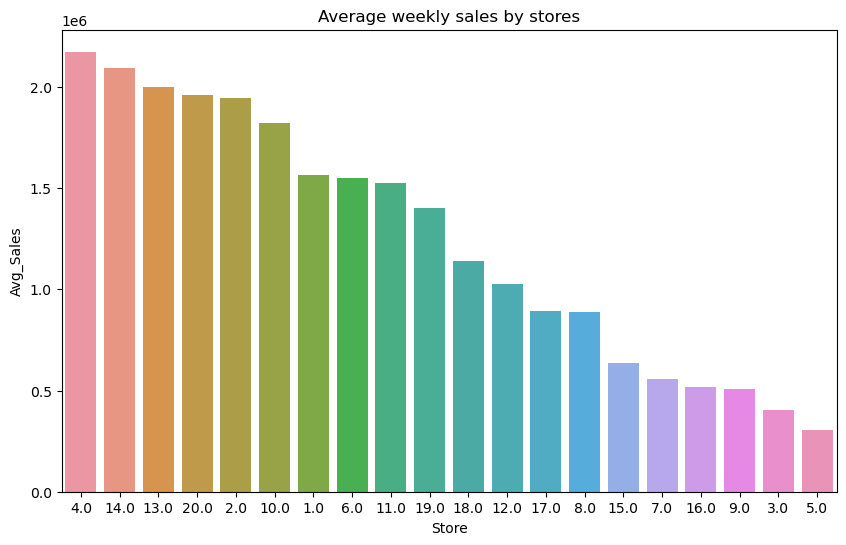

In [107]:
#Average weekly sales by stores
avg_sales_by_store = walmart_sales.groupby("Store")["Weekly_Sales"].mean().reset_index(name="Avg_Sales").sort_values(by="Avg_Sales",ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_sales_by_store["Store"], y=avg_sales_by_store["Avg_Sales"],order=avg_sales_by_store["Store"]).set_title("Average weekly sales by stores")
plt.show();

The stores have very different average weekly sales: the store number will probably have an impact on weekly sales. 

## Preprocessing

In [108]:
#Drop lines containing invalid values or outliers (here 3 times above or below standard deviation)
col_outliers = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for i in walmart_sales[col_outliers]: 
    outliers_min = walmart_sales[i].mean() - 3*walmart_sales[i].std()
    outliers_max = walmart_sales[i].mean() + 3*walmart_sales[i].std()
    to_keep = (walmart_sales[i]>outliers_min) & (walmart_sales[i]<outliers_max)
    walmart_sales = walmart_sales.loc[to_keep,:]

print('Done. Number of lines remaining : ', walmart_sales.shape[0])


Done. Number of lines remaining :  98


In [109]:
#Drop lines for the target Y (lines with missing values)
mask = walmart_sales["Weekly_Sales"].isnull()
walmart_sales = walmart_sales.drop(walmart_sales.loc[mask,:].index, axis=0)
walmart_sales

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
...,...,...,...,...,...,...,...,...
139,7.0,25-05-2012,532739.77,0.0,50.60,3.804,197.588605,8.090
143,3.0,04-06-2010,396968.80,0.0,78.53,2.705,214.495838,7.343
144,3.0,19-10-2012,424513.08,0.0,73.44,3.594,226.968844,6.034
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899


In [110]:
# See the dataset after
walmart_sales.describe(include="all")

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,90.000000,80,9.000000e+01,80.000000,90.00000,90.000000,90.000000,90.000000
unique,NaN,62,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,25-03-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.900000,NaN,1.233865e+06,0.075000,61.06100,3.318444,179.524905,7.389733
std,6.204475,NaN,6.647250e+05,0.265053,17.74604,0.484399,39.554303,0.982729
min,1.000000,NaN,2.689290e+05,0.000000,18.79000,2.548000,126.128355,5.143000
25%,4.000000,NaN,5.617240e+05,0.000000,45.34250,2.814750,132.602339,6.642250
50%,9.000000,NaN,1.260826e+06,0.000000,61.45000,3.468000,197.166416,7.419000
75%,15.750000,NaN,1.807159e+06,0.000000,75.79250,3.737750,214.855374,8.099000


Creation of new columns with year, month, day, day of week

In [111]:
# See the type of "Date" 
walmart_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         90 non-null     float64
 1   Date          80 non-null     object 
 2   Weekly_Sales  90 non-null     float64
 3   Holiday_Flag  80 non-null     float64
 4   Temperature   90 non-null     float64
 5   Fuel_Price    90 non-null     float64
 6   CPI           90 non-null     float64
 7   Unemployment  90 non-null     float64
dtypes: float64(7), object(1)
memory usage: 6.3+ KB


In [112]:
# Transform the type of column "Date" to Datetime
walmart_sales['Date'] = pd.to_datetime(walmart_sales['Date'])
walmart_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         90 non-null     float64       
 1   Date          80 non-null     datetime64[ns]
 2   Weekly_Sales  90 non-null     float64       
 3   Holiday_Flag  80 non-null     float64       
 4   Temperature   90 non-null     float64       
 5   Fuel_Price    90 non-null     float64       
 6   CPI           90 non-null     float64       
 7   Unemployment  90 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.3 KB


C:\Users\DDiallo\AppData\Local\Temp\ipykernel_40688\1618798415.py:2: UserWarning:

Parsing '18-02-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\DDiallo\AppData\Local\Temp\ipykernel_40688\1618798415.py:2: UserWarning:

Parsing '25-03-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\DDiallo\AppData\Local\Temp\ipykernel_40688\1618798415.py:2: UserWarning:

Parsing '28-05-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\DDiallo\AppData\Local\Temp\ipykernel_40688\1618798415.py:2: UserWarning:

Parsing '19-08-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\DDiallo\AppData\Local\Temp\ipykernel_40688\1618798415.py:2: UserWarning:

Parsing '15-10-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for c

In [113]:
#Drop the column "Date" and create new columns : year, month, day, day of week
walmart_sales["Year"] = walmart_sales["Date"].apply(lambda x : x.year)
walmart_sales["Month"] = walmart_sales["Date"].apply(lambda x : x.month)
walmart_sales["Day"] = walmart_sales["Date"].apply(lambda x : x.day)
walmart_sales["DayOfWeek"] = walmart_sales["Date"].apply(lambda x : x.dayofweek)
walmart_sales = walmart_sales.drop(["Date"], axis=1)
walmart_sales.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011.0,3.0,6.0,6.0
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012.0,3.0,2.0,4.0


In [114]:
walmart_sales.shape

(90, 11)

In [115]:
print("Percentage of missing values: ")
display(100*walmart_sales.isnull().sum()/walmart_sales.shape[0])

Percentage of missing values: 


Store            0.000000
Weekly_Sales     0.000000
Holiday_Flag    11.111111
Temperature      0.000000
Fuel_Price       0.000000
CPI              0.000000
Unemployment     0.000000
Year            11.111111
Month           11.111111
Day             11.111111
DayOfWeek       11.111111
dtype: float64

In [116]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = walmart_sales.loc[:,target_name]
X = walmart_sales.drop(target_name, axis = 1) # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
6   15.0           0.0        69.80       4.069  134.855161         7.658   
7   20.0           0.0        39.93       3.617  213.023622         6.961   

     Year  Month   Day  DayOfWeek  
0  2011.0    2.0  18.0        4.0  
1  2011.0    3.0  25.0        4.0  
4  2010.0    5.0  28.0        4.0  
6  2011.0    3.0   6.0        6.0  
7  2012.0    3.0   2.0        4.0  



In [117]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y ,test_size = 0.2, random_state = 42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [118]:
# Create pipeline for numeric features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"] # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [119]:
# Create pipeline for categorical features
categorical_features = ["Store", "Holiday_Flag"] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [120]:
# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
75    20.0           0.0        75.17       2.808  204.567546         7.856   
99    13.0           0.0        78.82       2.814  126.139200         7.951   
120    8.0           0.0        75.32       2.582  214.878556         6.315   
110   20.0           1.0        28.85       3.179  204.643227         7.484   
125    3.0           0.0        63.91       3.308  221.643285         7.197   

       Year  Month   Day  DayOfWeek  
75   2010.0    6.0  25.0        4.0  
99   2010.0    2.0   7.0        6.0  
120  2010.0    9.0  17.0        4.0  
110  2010.0   12.0  31.0        4.0  
125  2011.0   11.0  18.0        4.0  
...Done.
[[ 0.70516394 -1.13980519  0.62142729  0.48772018 -1.17754396 -0.13689148
   1.0717579   0.18629857  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0

c:\Users\DDiallo\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



In [121]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


Performance assessment

In [122]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[1908675.99645759 2033747.96019558  927076.49963643 1825829.36311943
  425328.77271114  250090.13528142  437394.82352599 1598614.82444868
  382661.80078768 1391761.26634149 1470796.91877038  527443.04057548
 1589219.25908565  977598.73280282  481585.19298081  401540.48827777
 2200052.32619696 1437713.22208585 1169667.1165331  1992903.25966294
 1120696.70705545 2029119.37743824  476109.4030002   451722.10188347
 1575085.8419644   410857.48233833 1569607.94        664761.17549414
 2191193.91116893  623337.52848748 1404187.20360266 1961998.10242309
  502260.23486292  452411.64733196  821900.51756075  966763.4382886
 1997442.56830751 1981012.89264944 1298074.17919962  622026.63029865
 2400517.66925977  628118.70121386  461276.4043943  1551724.23485352
 2082883.27830769 1105900.17339067  453743.04455692 1918388.1318007
 1783042.93970893 1531504.24650282 1041973.01473219 2084205.85042299
 1476776.87974638  463781.99363993  558725.98679441  356515.05508

In [123]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[2079026.40680778 1344424.83909108 1887882.8895951  1301648.09771698
 1634558.37281786  919861.63816356  875952.29493291 2453369.76239899
  714473.60928207 1909608.37063424 2203532.76571479 1933846.02484947
  516370.04014722  459305.52770167 1041832.3070418  2061637.02432822
  736059.70761451 1634265.10350295]



In [124]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9808346959682619
R2 score on test set :  0.9270713867152873


In [125]:
scores = cross_val_score(regressor, X_train, Y_train, cv = 5)  

print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

The cross-validated R2-score is :  0.7997878785670519
The standard deviation is :  0.2866451718138755


ASSESMENT of the linear regression model:
- Our dataset is very small (less than 100 observations)
- We should had more data to have more effective cv and to train correctly our model. 
- We could not say cleary if the model is overfitting : R2 score on test set is in the interval: [cross-validated R2 score +- std]

The model's coefficients

In [126]:
regressor.coef_

array([-3.03439577e+04, -4.88433711e+04,  1.07489001e+06, -2.22387543e+04,
       -7.28256400e+04,  2.80823655e+03, -3.81038240e+04, -2.08654832e+04,
        3.10251439e+05, -1.31730867e+06,  3.07585407e+06, -1.30802338e+06,
        4.83283050e+04, -4.30248833e+05, -8.00635713e+05, -1.24931418e+06,
        2.78164771e+06, -2.40913973e+05,  2.82347231e+06,  1.33559361e+06,
        1.36692795e+06, -4.79186934e+05,  1.46367840e+06,  1.71412572e+06,
        2.07975297e+06,  5.66379393e+05, -1.13657017e+05])

In [127]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'DayOfWeek', 'x0_2.0', 'x0_3.0', 'x0_4.0', 'x0_5.0', 'x0_6.0', 'x0_7.0', 'x0_8.0', 'x0_9.0', 'x0_10.0', 'x0_11.0', 'x0_13.0', 'x0_14.0', 'x0_15.0', 'x0_16.0', 'x0_17.0', 'x0_18.0', 'x0_19.0', 'x0_20.0', 'x1_1.0']


In [128]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
Temperature,-3.034396e+04
Fuel_Price,-4.884337e+04
CPI,1.074890e+06
Unemployment,-2.223875e+04
Year,-7.282564e+04
Month,2.808237e+03
Day,-3.810382e+04
DayOfWeek,-2.086548e+04
x0_2.0,3.102514e+05
x0_3.0,-1.317309e+06


In [129]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients', ascending=False)
feature_importance

,coefficients
x0_4.0,3.075854e+06
x0_13.0,2.823472e+06
x0_10.0,2.781648e+06
x0_19.0,2.079753e+06
x0_18.0,1.714126e+06
x0_17.0,1.463678e+06
x0_15.0,1.366928e+06
x0_14.0,1.335594e+06
x0_3.0,1.317309e+06
x0_5.0,1.308023e+06


In [130]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

What features are important for the prediction ?
- the store (in order stores number 4,10,18,15,3,9,8,16,2)
- CPI 

REGULARIZED LINEAR REGRESSION MODEL

Ridge

In [131]:
ridge1 = Ridge(alpha=0.01)
print(ridge1)
ridge1.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", ridge1.score(X_train, Y_train))
print("R2 score on test set : ", ridge1.score(X_test, Y_test))

Ridge(alpha=0.01)
R2 score on training set :  0.979481350888807
R2 score on test set :  0.9432621256757973


In [132]:
data_dict = {
    'Feature': column_names,
    'Ridge1': ridge1.coef_,
            }

coefficients_ridge = pd.DataFrame(data = data_dict)
coefficients_ridge.head(30)

,Feature,Ridge1
0,Temperature,-3.094708e+04
1,Fuel_Price,-4.819207e+04
2,CPI,2.127449e+05
3,Unemployment,-2.987300e+04
4,Year,-4.757663e+03
5,Month,1.329138e+04
6,Day,-3.927419e+04
7,DayOfWeek,-1.814725e+04
8,x0_2.0,3.109808e+05
9,x0_3.0,-1.212948e+06


In [133]:
fig = px.line(coefficients_ridge, x = 'Feature', y = ['Ridge1'])
fig.show()

Lasso

In [134]:
lasso1 = Lasso(alpha = 1, max_iter=100000)   
print(lasso1)
lasso1.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", lasso1.score(X_train, Y_train))
print("R2 score on test set : ", lasso1.score(X_test, Y_test)) 

Lasso(alpha=1, max_iter=100000)
R2 score on training set :  0.9808339395751694
R2 score on test set :  0.9276263420002715


In [135]:
data_dict = {
    'Feature': column_names,
    'Lasso1': lasso1.coef_,
            }

coefficients_lasso = pd.DataFrame(data = data_dict)
coefficients_lasso.head(30)

,Feature,Lasso1
0,Temperature,-3.037532e+04
1,Fuel_Price,-4.878597e+04
2,CPI,1.054341e+06
3,Unemployment,-2.255015e+04
4,Year,-7.129489e+04
5,Month,3.041831e+03
6,Day,-3.811766e+04
7,DayOfWeek,-2.082775e+04
8,x0_2.0,3.100541e+05
9,x0_3.0,-1.315116e+06


In [136]:
fig = px.line(coefficients_lasso, x = 'Feature', y = ['Lasso1'])
fig.show() 

Hyperparameter optimization

In [137]:
# Perform grid search RIDGE
print("Grid search...")
regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
best_ridge = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
best_ridge.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.01}
Best R2 score :  0.9383168472909229


In [138]:
# Perform grid search LASSO
print("Grid search...")
regressor = Lasso(max_iter=100000)
# Grid of values to be tested
params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30],
}
best_lasso = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
best_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 30}
Best R2 score :  0.9047923979750403


Comparing models

In [139]:
# Print R^2 scores
print("RIDGE / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("RIDGE / R2 score on test set : ", best_ridge.score(X_test, Y_test))
print()
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

RIDGE / R2 score on training set :  0.979481350888807
RIDGE / R2 score on test set :  0.9432621256757973

LASSO / R2 score on training set :  0.9801587604228551
LASSO / R2 score on test set :  0.939633183782666


In [140]:
data_dict = {
    'Feature': column_names,
    'Best_Ridge': best_ridge.best_estimator_.coef_,
    'Best_Lasso': best_lasso.best_estimator_.coef_
            }

coefficients = pd.DataFrame(data = data_dict)
coefficients.head(30)

,Feature,Best_Ridge,Best_Lasso
0,Temperature,-3.094708e+04,-3.128147e+04
1,Fuel_Price,-4.819207e+04,-4.712566e+04
2,CPI,2.127449e+05,4.606130e+05
3,Unemployment,-2.987300e+04,-3.154099e+04
4,Year,-4.757663e+03,-2.706572e+04
5,Month,1.329138e+04,9.790311e+03
6,Day,-3.927419e+04,-3.851674e+04
7,DayOfWeek,-1.814725e+04,-1.973697e+04
8,x0_2.0,3.109808e+05,3.043525e+05
9,x0_3.0,-1.212948e+06,-1.251746e+06


In [141]:
fig = px.line(coefficients, x = 'Feature', y = ['Best_Ridge', 'Best_Lasso'])
fig.show()

- Ridge is better than Lasso: R2 score on test is higher 
- R2 score of Ridge is better than linear regression 
- Ridge : strong coefficients on stores and CPI